In [1]:
# gbm이란 틀린 부분에 가중치를 더하면서 진행하는 알고리즘

# # 안건들여도 될것 같은거
#     boosting_type: str = 'gbdt',
#     learning_rate: float = 0.1, - 건들면 좋을 것 같긴한데 학습시간에 많은 영향이 있을 것으로 예상되어 마지막에
#     objective: Union[str, Callable, NoneType] = None,
#     class_weight: Union[Dict, str, NoneType] = None,
#     random_state: Union[int, numpy.random.mtrand.RandomState, NoneType] = None,
#     subsample: float = 1.0, - # 훈련 인스턴스의 하위 샘플 비율입니다
#     subsample_freq: int = 0, - # 서브샘플의 빈도, <=0은 활성화가 없음을 의미
#     n_jobs: int = -1, - # 병렬 스레드 수, 병렬처리 여부, -1이면 모든 코어 사용
#     silent: Union[bool, str] = 'warn', - # 부스팅을 실행하는 동안 메시지를 인쇄할지 여부
#     importance_type: str = 'split',

# # 100까지 올렸을 때 정확도가 올라가는 것으로 보임, 딱히 과적합이 양상이 보이지 않음
# # 120부터 4.2대로 나오기 시작했지만 150번째에서 4.19가 찍힘
#     num_leaves: int = 31, - 전체 Tree의 leave 수 이고, 디폴트값은 31
# 	- 개별 트리가 가질 수 있는 최대 리프의 개수를 지정, lightgbm복잡도를 제어하는 주 파라미터
# 	- 수가 커질 수록 모델의 깊이가 깊어지므로 모델 정확도가 높아지지만 과적합 발생 확률 또한 높아짐
# # 맥스딥스로는 큰 효과를 못봄, -1, 0, 11, 12, 에서 5.06, 5.07정도의 값이 나옴 15에서 5.02가 나오긴 함
#     max_depth: int = -1,  - tree의 최대 깊이, 모델 과적합을 다룰때 사용, 과적합으로 느끼면 값을 줄여야함
# # 적합하도록 부스트된 나무의 수
#     n_estimators: int = 100, - # 트리의 갯수 높을 수록 정확도가 높아지나 시간이 오래 걸림



# # 과적합 개선에 사용되는 파라미터
#     reg_alpha: float = 0.0, - # 가중치에 대한 L1 정규화 항
#     reg_lambda: float = 0.0, - # 가중치에 대한 L2 정규화 항



# ------------------------------------------------------------------------------------------------------------------
# # bin구성을 위한 샘플 수
#     subsample_for_bin: int = 200000,

# # 트리의 리프 노드에서 추가 파티션을 만드는 데 필요한 최소 손실 감소
#     min_split_gain: float = 0.0,

# # 자식(리프)에 필요한 인스턴스 가중치(헤시안)의 최소 합계
#     min_child_weight: float = 0.001,

# # 자식(리프)에 필요한 최소 데이터
#     min_child_samples: int = 20,

# # 각 트리를 구성할 때 열의 하위 샘플 비율
#     colsample_bytree: float = 1.0,




In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb

In [43]:
# 데이터 로드

train = pd.read_parquet('./train_pwm.parquet')
train.head()

,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,...,start_latitude,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted,target,weekend,month
0,TRAIN_0000000,20220623,1,17,1,106,지방도1112호선,0,0,60.0,...,33.427747,126.662612,0,제3교래교,33.427749,126.662335,0,52.0,0,6
1,TRAIN_0000001,20220728,1,21,2,103,일반국도11호선,0,0,60.0,...,33.500730,126.529107,1,KAL사거리,33.504811,126.526240,0,30.0,0,7
2,TRAIN_0000002,20211010,4,7,2,103,일반국도16호선,0,0,80.0,...,33.279145,126.368598,0,상창육교,33.280072,126.362147,0,61.0,1,10
3,TRAIN_0000003,20220311,0,13,2,107,태평로,0,0,50.0,...,33.246081,126.567204,0,서현주택,33.245565,126.566228,0,20.0,0,3
4,TRAIN_0000004,20211005,6,8,2,103,일반국도12호선,0,0,80.0,...,33.462214,126.326551,0,애월입구,33.462677,126.330152,0,38.0,0,10


In [45]:
from sklearn.utils import shuffle

tr = shuffle(train.sort_values('base_date')[train['base_date'] < 20220701])
te = shuffle(train.sort_values('base_date')[train['base_date'] > 20220631])

y_train = tr['target']
X_train = tr.drop(['day_of_week', 'multi_linked', 'connect_code', 'height_restricted', 'id','base_date', 'target','road_name', 'start_node_name', 'end_node_name','vehicle_restricted'], axis=1)

y_test = te['target']
X_test = te.drop(['day_of_week', 'multi_linked', 'connect_code', 'height_restricted', 'id','base_date', 'target','road_name', 'start_node_name', 'end_node_name','vehicle_restricted'], axis=1)


print(X_train.shape)
print(y_train.shape)
print(X_test.shape)

C:\Users\knzss\AppData\Local\Temp\ipykernel_3000\489013793.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tr = shuffle(train.sort_values('base_date')[train['base_date'] < 20220701])
C:\Users\knzss\AppData\Local\Temp\ipykernel_3000\489013793.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  te = shuffle(train.sort_values('base_date')[train['base_date'] > 20220631])


(4426522, 14)
(4426522,)
(274695, 14)


In [8]:
# 15, 186부터 3점대

from sklearn.metrics import mean_absolute_error

mae_list = []

check_max_depth = 0
check_num_leaves = 0

min_num = 10
min_stack = 0
stop_num = 3

for max_depth in range(5, 20):
    for num_leaves in range(115, 200):
        LR = lgb.LGBMRegressor(random_state = 42,
                               num_leaves  = num_leaves,
                               max_depth = max_depth
                              ).fit(X_train, y_train)

        pred = LR.predict(X_test)
        mae = mean_absolute_error(pred, y_test)

        if min_num > mae:
            min_stack = 0
            check_max_depth = max_depth
            check_num_leaves = num_leaves
            min_num = mae
            print('max_depth : ', max_depth, 'num_leaves : ', num_leaves, ', mae : ', mae)
        elif min_stack != stop_num:
            min_stack += 1
            min_num = mae
            print('max_depth : ', max_depth, 'num_leaves : ', num_leaves, ', mae : ', mae)
        elif min_stack == stop_num:
            break

max_depth :  5 num_leaves :  115 , mae :  5.485367770810115
max_depth :  5 num_leaves :  116 , mae :  5.485367770810115
max_depth :  5 num_leaves :  117 , mae :  5.485367770810115
max_depth :  5 num_leaves :  118 , mae :  5.485367770810115
max_depth :  6 num_leaves :  115 , mae :  5.05879799741556
max_depth :  6 num_leaves :  116 , mae :  5.05879799741556
max_depth :  6 num_leaves :  117 , mae :  5.05879799741556
max_depth :  6 num_leaves :  118 , mae :  5.05879799741556
max_depth :  7 num_leaves :  115 , mae :  4.724480557794017
max_depth :  7 num_leaves :  116 , mae :  4.689725576016151
max_depth :  7 num_leaves :  117 , mae :  4.707208561290534
max_depth :  7 num_leaves :  118 , mae :  4.691524263375019
max_depth :  7 num_leaves :  119 , mae :  4.727871045309281
max_depth :  7 num_leaves :  120 , mae :  4.726675771425921
max_depth :  7 num_leaves :  121 , mae :  4.694615571741986
max_depth :  7 num_leaves :  122 , mae :  4.69516395027926
max_depth :  7 num_leaves :  123 , mae :  4.7

max_depth :  9 num_leaves :  142 , mae :  4.241415582362595
max_depth :  9 num_leaves :  143 , mae :  4.2527990272465175
max_depth :  9 num_leaves :  144 , mae :  4.225060248541164
max_depth :  9 num_leaves :  145 , mae :  4.2387410339296085
max_depth :  9 num_leaves :  146 , mae :  4.248945567568691
max_depth :  9 num_leaves :  147 , mae :  4.229457619946918
max_depth :  9 num_leaves :  148 , mae :  4.210683539257498
max_depth :  9 num_leaves :  149 , mae :  4.239426150827303
max_depth :  9 num_leaves :  150 , mae :  4.240120565424692
max_depth :  9 num_leaves :  151 , mae :  4.204910310184635
max_depth :  9 num_leaves :  152 , mae :  4.238462787509401
max_depth :  9 num_leaves :  153 , mae :  4.235739513720017
max_depth :  9 num_leaves :  154 , mae :  4.188247038890455
max_depth :  9 num_leaves :  155 , mae :  4.196205754216192
max_depth :  9 num_leaves :  156 , mae :  4.2389935932258
max_depth :  9 num_leaves :  157 , mae :  4.217374254782627
max_depth :  9 num_leaves :  158 , mae :

max_depth :  10 num_leaves :  193 , mae :  4.061224273124137
max_depth :  10 num_leaves :  194 , mae :  4.058107550205032
max_depth :  10 num_leaves :  195 , mae :  4.078169837852124
max_depth :  10 num_leaves :  196 , mae :  4.106203295156387
max_depth :  10 num_leaves :  197 , mae :  4.040842995219675
max_depth :  10 num_leaves :  198 , mae :  4.046430157593961
max_depth :  10 num_leaves :  199 , mae :  4.0842999162768425
max_depth :  11 num_leaves :  115 , mae :  4.229670049777981
max_depth :  14 num_leaves :  115 , mae :  4.220350369188956
max_depth :  14 num_leaves :  116 , mae :  4.231296567043673
max_depth :  14 num_leaves :  117 , mae :  4.222538605575468
max_depth :  14 num_leaves :  118 , mae :  4.1893005644516785
max_depth :  14 num_leaves :  119 , mae :  4.236751943611883
max_depth :  14 num_leaves :  120 , mae :  4.205259967886615
max_depth :  14 num_leaves :  121 , mae :  4.227051604656126
max_depth :  14 num_leaves :  122 , mae :  4.204425132514624
max_depth :  14 num_le

max_depth :  15 num_leaves :  157 , mae :  4.082397270353137
max_depth :  15 num_leaves :  158 , mae :  4.084254971583719
max_depth :  15 num_leaves :  159 , mae :  4.0578923728711285
max_depth :  15 num_leaves :  160 , mae :  4.051451125029961
max_depth :  15 num_leaves :  161 , mae :  4.049277367958111
max_depth :  15 num_leaves :  162 , mae :  4.088786432335148
max_depth :  15 num_leaves :  163 , mae :  4.058089009231115
max_depth :  15 num_leaves :  164 , mae :  4.071302083341905
max_depth :  15 num_leaves :  165 , mae :  4.082547118863917
max_depth :  15 num_leaves :  166 , mae :  4.07440780363436
max_depth :  15 num_leaves :  167 , mae :  4.054988239303099
max_depth :  15 num_leaves :  168 , mae :  4.035060916010847
max_depth :  15 num_leaves :  169 , mae :  4.035656791910826
max_depth :  15 num_leaves :  170 , mae :  4.0335114227816415
max_depth :  15 num_leaves :  171 , mae :  4.044365137611432
max_depth :  15 num_leaves :  172 , mae :  4.0393052514734915
max_depth :  15 num_le

In [ ]:
from sklearn.metrics import mean_absolute_error

mae_list = []

check_max_depth = 0
check_num_leaves = 0

min_num = 10
min_stack = 0
stop_num = 3

for max_depth in range(15, 30):
    for num_leaves in range(185, 250):
        LR = lgb.LGBMRegressor(random_state = 42,
                               num_leaves  = num_leaves,
                               max_depth = max_depth
                              ).fit(X_train, y_train)

        pred = LR.predict(X_test)
        mae = mean_absolute_error(pred, y_test)

        if min_num > mae:
            min_stack = 0
            check_max_depth = max_depth
            check_num_leaves = num_leaves
            min_num = mae
            print('max_depth : ', max_depth, 'num_leaves : ', num_leaves, ', mae : ', mae)
        elif min_stack != stop_num:
            min_stack += 1
            min_num = mae
            print('max_depth : ', max_depth, 'num_leaves : ', num_leaves, ', mae : ', mae)
        elif min_stack == stop_num:
            break

In [56]:
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV



LR = lgb.LGBMRegressor()

### parameter 들을 dictionary 형태로 설정
parameters = {'max_depth':[15],
              'num_leaves':[187, 188],
              'learning_rate' : [0.5, 0.6]}

# param_grid의 하이퍼 파라미터들을 3개의 train, test set fold 로 나누어서 테스트 수행 설정.  
### refit=True 가 default 임. True이면 가장 좋은 파라미터 설정으로 재 학습 시킴.  
grid_lr = GridSearchCV(LR, param_grid=parameters, cv=3, refit=True)

# 붓꽃 Train 데이터로 param_grid의 하이퍼 파라미터들을 순차적으로 학습/평가 .
grid_lr.fit(X_train, y_train)

# GridSearchCV 결과 추출하여 DataFrame으로 변환
scores_df = pd.DataFrame(grid_lr.cv_results_)
scores_df[['params', 'mean_test_score', 'rank_test_score', 
           'split0_test_score', 'split1_test_score', 'split2_test_score']]


,params,mean_test_score,rank_test_score,split0_test_score,split1_test_score,split2_test_score
0,"{'learning_rate': 0.5, 'max_depth': 15, 'num_l...",0.913571,3,0.913016,0.912929,0.914769
1,"{'learning_rate': 0.5, 'max_depth': 15, 'num_l...",0.913552,4,0.912757,0.912828,0.915072
2,"{'learning_rate': 0.6, 'max_depth': 15, 'num_l...",0.913855,1,0.913297,0.913152,0.915114
3,"{'learning_rate': 0.6, 'max_depth': 15, 'num_l...",0.913805,2,0.913251,0.913030,0.915134


In [99]:
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV

LR = lgb.LGBMRegressor()

parameters = {'max_depth':[15, 16],
              'num_leaves':[187, 188],
              'learning_rate' : [0.5, 0.6],
              'n_estimators' : [293, 294]
             }

grid_lr = GridSearchCV(LR, param_grid=parameters, cv=3, refit=True)

grid_lr.fit(X_train, y_train)

scores_df = pd.DataFrame(grid_lr.cv_results_)
scores_df[['params', 'mean_test_score', 'rank_test_score', 
           'split0_test_score', 'split1_test_score', 'split2_test_score']]


,params,mean_test_score,rank_test_score,split0_test_score,split1_test_score,split2_test_score
0,"{'learning_rate': 0.5, 'max_depth': 15, 'n_est...",0.916434,8,0.915852,0.915851,0.917597
1,"{'learning_rate': 0.5, 'max_depth': 15, 'n_est...",0.916441,6,0.915812,0.915736,0.917776
2,"{'learning_rate': 0.5, 'max_depth': 15, 'n_est...",0.916439,7,0.915857,0.915861,0.917600
3,"{'learning_rate': 0.5, 'max_depth': 15, 'n_est...",0.916447,5,0.915817,0.915742,0.917781
4,"{'learning_rate': 0.5, 'max_depth': 16, 'n_est...",0.916474,4,0.915746,0.915862,0.917815
5,"{'learning_rate': 0.5, 'max_depth': 16, 'n_est...",0.916591,2,0.915974,0.915931,0.917869
6,"{'learning_rate': 0.5, 'max_depth': 16, 'n_est...",0.916478,3,0.915746,0.915869,0.917818
7,"{'learning_rate': 0.5, 'max_depth': 16, 'n_est...",0.916596,1,0.915977,0.915934,0.917877
8,"{'learning_rate': 0.6, 'max_depth': 15, 'n_est...",0.916294,10,0.915723,0.915546,0.917614
9,"{'learning_rate': 0.6, 'max_depth': 15, 'n_est...",0.916258,15,0.915666,0.915573,0.917534


In [102]:
grid_lr.cv_results_['params'][7]

{'learning_rate': 0.5, 'max_depth': 16, 'n_estimators': 294, 'num_leaves': 188}

In [61]:
f_list = [i for i in range(15, 50)]
mae_list = []
min_num = 10
min_stack = 0
stop_num = 3

for i in f_list:

    LR = lgb.LGBMRegressor(random_state = 42,
                           max_depth = i,
                           num_leaves = 187,
                           learning_rate = 0.6,
                           n_estimators = 177,
    #                        reg_lambda = 0.01
                          ).fit(X_train, y_train)

    pred = LR.predict(X_test)
    mae = mean_absolute_error(pred, y_test)
    print(mae)

    if min_num > mae:
        min_stack = 0
        mae_list.append((i, mae))
        min_num = mae
        print('max_depth : ', i, ', mae : ', mae)
    elif min_stack != stop_num:
        min_stack += 1
        mae_list.append((i, mae))
        min_num = mae
        print('max_depth : ', i, ', mae : ', mae)
    elif min_stack == stop_num:
        break
#         pass

3.6203461223850097
max_depth :  15 , mae :  3.6203461223850097
3.61689002167885
max_depth :  16 , mae :  3.61689002167885
3.617534303895066
max_depth :  17 , mae :  3.617534303895066
3.6128050674436416
max_depth :  18 , mae :  3.6128050674436416
3.6188660343306136
max_depth :  19 , mae :  3.6188660343306136
3.6082254470161836
max_depth :  20 , mae :  3.6082254470161836
3.6205621752937276
max_depth :  21 , mae :  3.6205621752937276
3.609805600108715
max_depth :  22 , mae :  3.609805600108715
3.6341644694917266
max_depth :  23 , mae :  3.6341644694917266
3.6088862549258134
max_depth :  24 , mae :  3.6088862549258134
3.6236360059351074
max_depth :  25 , mae :  3.6236360059351074
3.621990894306523
max_depth :  26 , mae :  3.621990894306523
3.612335881958639
max_depth :  27 , mae :  3.612335881958639
3.616587180685243
max_depth :  28 , mae :  3.616587180685243
3.6191680076626516
max_depth :  29 , mae :  3.6191680076626516
3.605686624984051
max_depth :  30 , mae :  3.605686624984051
3.605686

In [63]:
# grid_dtree.cv_results_
LR = lgb.LGBMRegressor(random_state = 42,
                           max_depth = 30,
                           num_leaves = 187,
                           learning_rate = 0.6,
                           n_estimators = 177,
                           reg_lambda = 0.01
                          ).fit(X_train, y_train)

pred = LR.predict(X_test)
mae = mean_absolute_error(pred, y_test)
print(mae, LR.feature_importances_)

3.6224544998730135 [8889 1110  934  974  399  177 4066 3227  157 3225 2488  109 1578 5589]


In [65]:
importances = pd.Series(LR.feature_importances_, X_train.columns)
importances

base_hour                8889
lane_count               1110
road_rating               934
maximum_speed_limit       974
weight_restricted         399
road_type                 177
start_latitude           4066
start_longitude          3227
start_turn_restricted     157
end_latitude             3225
end_longitude            2488
end_turn_restricted       109
weekend                  1578
month                    5589
dtype: int32

<AxesSubplot:>

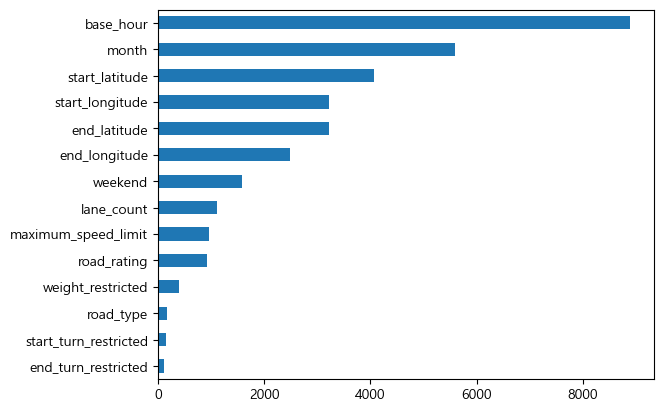

In [66]:
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns

rc('font', family = 'Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

%matplotlib inline


# plt.title(f'Top {n} features')
importances.sort_values().plot.barh()

In [38]:
xt = X_train.copy()

xt['target'] = y_train

xt

,base_hour,lane_count,road_rating,maximum_speed_limit,weight_restricted,road_type,start_latitude,start_longitude,start_turn_restricted,end_latitude,end_longitude,end_turn_restricted,weekend,month,target
1260688,3,2,106,50.0,0.0,0,33.452396,126.344994,0,33.451901,126.341998,0,1,6,44.0
3965699,21,2,103,80.0,0.0,0,33.446409,126.434972,0,33.444996,126.433332,0,1,9,65.0
4393029,23,2,103,70.0,0.0,0,33.550675,126.795673,0,33.546078,126.804045,0,1,9,63.0
1236401,0,2,106,60.0,0.0,0,33.447183,126.912579,0,33.445847,126.903808,0,0,12,45.0
1378070,0,1,107,50.0,0.0,0,33.450215,126.920771,0,33.460276,126.930941,0,0,3,59.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3442542,6,3,106,70.0,0.0,0,33.488699,126.597621,1,33.485707,126.604162,1,1,12,31.0
4473754,1,2,107,60.0,0.0,0,33.253900,126.506693,0,33.254782,126.507014,0,1,1,45.0
1964494,2,3,106,70.0,0.0,0,33.255106,126.540832,0,33.246996,126.524358,0,0,9,56.0
859528,11,2,103,70.0,0.0,0,33.382161,126.236043,0,33.387538,126.249127,0,0,5,58.0


In [39]:
xt.corr()

,base_hour,lane_count,road_rating,maximum_speed_limit,weight_restricted,road_type,start_latitude,start_longitude,start_turn_restricted,end_latitude,end_longitude,end_turn_restricted,weekend,month,target
base_hour,1.000000,-0.029529,0.032695,-0.038158,-0.003741,-0.007942,-0.022165,-0.011810,-0.012478,-0.022160,-0.011821,-0.012614,0.009475,0.002265,-0.158596
lane_count,-0.029529,1.000000,-0.100050,0.382190,-0.176104,-0.055785,0.172184,-0.103655,0.294704,0.171851,-0.103584,0.314053,0.000989,0.000764,-0.141434
road_rating,0.032695,-0.100050,1.000000,-0.328717,-0.116102,-0.121890,-0.197821,0.005962,-0.025326,-0.197877,0.005950,-0.025738,-0.002306,-0.005715,-0.260453
maximum_speed_limit,-0.038158,0.382190,-0.328717,1.000000,0.087402,0.060384,0.245347,-0.036321,0.090746,0.245173,-0.036231,0.100848,0.001512,0.003922,0.432182
weight_restricted,-0.003741,-0.176104,-0.116102,0.087402,1.000000,0.803042,-0.128324,0.036524,-0.119463,-0.128337,0.036512,-0.119327,0.000644,0.002413,0.290456
road_type,-0.007942,-0.055785,-0.121890,0.060384,0.803042,1.000000,-0.049516,0.035557,-0.103457,-0.049525,0.035535,-0.103281,0.000918,0.003779,0.198994
start_latitude,-0.022165,0.172184,-0.197821,0.245347,-0.128324,-0.049516,1.000000,0.127601,0.275823,0.999041,0.127561,0.276142,0.001267,0.002755,0.036461
start_longitude,-0.011810,-0.103655,0.005962,-0.036321,0.036524,0.035557,0.127601,1.000000,0.041304,0.127447,0.999241,0.041119,-0.000774,0.000812,0.000786
start_turn_restricted,-0.012478,0.294704,-0.025326,0.090746,-0.119463,-0.103457,0.275823,0.041304,1.000000,0.276193,0.041045,0.411219,0.000592,-0.001230,-0.156077
end_latitude,-0.022160,0.171851,-0.197877,0.245173,-0.128337,-0.049525,0.999041,0.127447,0.276193,1.000000,0.127653,0.276078,0.001261,0.002720,0.036319


In [ ]:
from sklearn.metrics import mean_absolute_error


mae_list = []
min_num = 10
min_stack = 0
stop_num = 3

# test, max_depth
# 맥스딥스로는 큰 효과를 못봄, -1, 0, 11, 12, 에서 5.06, 5.07정도의 값이 나옴 15에서 5.02가 나오긴 함
for i in range(-1, 20):
    LR = lgb.LGBMRegressor(random_state = 42,
                           max_depth = i
                          ).fit(X_train, y_train)

    pred = LR.predict(X_test)
    mae = mean_absolute_error(pred, y_test)
    
    if min_num > mae:
        min_stack = 0
        mae_list.append((i, mae))
        min_num = mae
        print('max_depth : ', i, ', mae : ', mae)
    elif min_stack != stop_num:
        min_stack += 1
        mae_list.append((i, mae))
        min_num = mae
        print('max_depth : ', i, ', mae : ', mae)
    elif min_stack == stop_num:
        break
            

In [ ]:
# test, num_leaves
# 100까지 올렸을 때 정확도가 올라가는 것으로 보임, 딱히 과적합이 양상이 보이지 않음
# 120부터 4.2대로 나오기 시작했지만 150번째에서 4.19가 찍힘
default = 100
max_num_t = 150

for i in range(default, max_num_t + 1):
    LR = lgb.LGBMRegressor(random_state = 42,
                           num_leaves  = i
                          ).fit(X_train, y_train)

    pred = LR.predict(X_test)
    mae = mean_absolute_error(pred, y_test)
    
    if min_num > mae:
        min_stack = 0
        mae_list.append((i, mae))
        min_num = mae
        print('num_leaves  : ', i, ', mae : ', mae)
    elif min_stack != stop_num:
        min_stack += 1
        mae_list.append((i, mae))
        min_num = mae
        print('num_leaves  : ', i, ', mae : ', mae)
    elif min_stack == stop_num:
        break

In [46]:
from sklearn.metrics import mean_absolute_error
# test, num_leaves
# 100까지 올렸을 때 정확도가 올라가는 것으로 보임, 딱히 과적합이 양상이 보이지 않음
# 120부터 4.2대로 나오기 시작했지만 150번째에서 4.19가 찍힘
default = 293
max_num_t = 320

min_num = 10
min_stack = 0
stop_num = 3

# for i in range(default, max_num_t + 1):
LR = lgb.LGBMRegressor(random_state = 42,
                       max_depth = 15, # 원핫 - 20
                       num_leaves = 187, # 200
                       n_estimators = 294,
                       learning_rate = 0.4,

#                            min_split_gain = (i / 100), # 0.0 mae값이 올라버림, 값이 오름에 따라
#                            min_child_weight = (i / 1000), # 영향 미비
#                            min_child_samples = i, # 20 미비
#                            colsample_bytree = (i / 10), # 1.0이 젤 좋음
#                            reg_lambda = (i / 100),
                      ).fit(X_train, y_train)

pred = LR.predict(X_test)
mae = mean_absolute_error(pred, y_test)
print(mae)
#     if min_num > mae:
#         min_stack = 0
#         min_num = mae
#         print('파라미터 값  : ', i, ', mae : ', mae)
#     elif min_stack != stop_num:
#         min_stack += 1
#         min_num = mae
#         print('파라미터 값  : ', i, ', mae : ', mae)
#     elif min_stack == stop_num:
#         break

3.5956313298909737


In [ ]:
어떻게 범위를찾았는지

In [ ]:
모델, 그리드

In [172]:
X_train

,lane_count,road_rating,maximum_speed_limit,weight_restricted,road_type,start_latitude,start_longitude,start_turn_restricted,end_latitude,end_longitude,...,0,1,2,3,4,0,1,2,3,4
624837,2,103,50.0,0.0,0,33.447183,126.912579,0,33.450294,126.912167,...,0,0,0,1,0,0,0,0,1,0
1485623,3,103,70.0,0.0,0,33.488395,126.483507,1,33.490078,126.486558,...,1,0,0,0,0,1,0,0,0,0
3534638,2,106,70.0,0.0,0,33.451404,126.369122,1,33.451731,126.366077,...,0,0,0,1,0,0,0,0,1,0
3496215,2,103,80.0,0.0,0,33.413158,126.396837,0,33.414011,126.398140,...,1,0,0,0,0,1,0,0,0,0
2454543,1,107,60.0,43200.0,3,33.337244,126.695809,0,33.337398,126.696117,...,0,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2026009,2,106,70.0,0.0,0,33.451731,126.366077,0,33.451404,126.369122,...,1,0,0,0,0,1,0,0,0,0
130183,1,106,60.0,43200.0,3,33.290116,126.489006,0,33.289861,126.487409,...,0,0,1,0,0,0,0,1,0,0
2684240,2,107,60.0,0.0,0,33.247607,126.561943,0,33.244601,126.562080,...,0,1,0,0,0,0,1,0,0,0
3057918,2,103,80.0,0.0,0,33.433794,126.420435,0,33.436550,126.423971,...,0,1,0,0,0,0,1,0,0,0


ValueError: DataFrame.dtypes for data must be int, float or bool.
Did not expect the data types in the following fields: month

In [105]:
# 데이터 크롤링, 기업이 어떤 영향을 미치는지 이슈 분석
# 버트 모델?

pred = LR.predict(X_test.iloc[1])

ValueError: Expected 2D array, got 1D array instead:
array=[ 21.           1.         107.          30.           0.
   0.          33.49984849 126.51987167   1.          33.49815102
 126.51983404   0.           0.           7.        ].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [106]:
X_train.head()

,base_hour,lane_count,road_rating,maximum_speed_limit,weight_restricted,road_type,start_latitude,start_longitude,start_turn_restricted,end_latitude,end_longitude,end_turn_restricted,weekend,month
3352471,9,2,103,60.0,43200.0,3,33.265988,126.414267,0,33.266040,126.414029,0,0,2
990152,23,2,107,70.0,0.0,0,33.516800,126.524828,0,33.516710,126.530479,0,0,1
3893450,13,2,103,60.0,0.0,0,33.305867,126.599081,1,33.308236,126.598690,0,0,9
1401463,18,2,106,70.0,0.0,0,33.452734,126.385337,1,33.453324,126.390354,0,0,10
2702877,8,1,103,60.0,0.0,0,33.534783,126.642521,0,33.536816,126.658816,0,1,10


[0, 1, 0, 0, 0, 0, 0, 0, 0]

In [134]:
from sklearn.preprocessing import OneHotEncoder

oh = OneHotEncoder(sparse = False)

oh.fit(np.array(train['month']).reshape(-1, 1))

OneHotEncoder(sparse=False)

In [135]:
oh_encoded = oh.transform(np.array(train['month']).reshape(-1, 1))
oh_encoded

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

In [136]:
train['month'] = list(oh_encoded)

In [137]:
train.head()

,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,...,start_latitude,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted,target,weekend,month
0,TRAIN_0000000,20220623,1,17,1,106,지방도1112호선,0,0,60.0,...,33.427747,126.662612,0,제3교래교,33.427749,126.662335,0,52.0,0,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
1,TRAIN_0000001,20220728,1,21,2,103,일반국도11호선,0,0,60.0,...,33.500730,126.529107,1,KAL사거리,33.504811,126.526240,0,30.0,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
2,TRAIN_0000002,20211010,4,7,2,103,일반국도16호선,0,0,80.0,...,33.279145,126.368598,0,상창육교,33.280072,126.362147,0,61.0,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
3,TRAIN_0000003,20220311,0,13,2,107,태평로,0,0,50.0,...,33.246081,126.567204,0,서현주택,33.245565,126.566228,0,20.0,0,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,TRAIN_0000004,20211005,6,8,2,103,일반국도12호선,0,0,80.0,...,33.462214,126.326551,0,애월입구,33.462677,126.330152,0,38.0,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."


In [131]:
list(oh_encoded)

[array([0., 1., 0., 0., 0., 0., 0., 0., 0.]),
 array([1., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 1., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 1., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 1., 0., 0.]),
 array([0., 1., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 1., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 1., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([1., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([1., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 1., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 1., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 1., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 1., 0., 0., 0.]),
 array([0., 0., 0., 1., 0., 0., 0., 0., 0.]),
 array([0., 0., 1., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 1., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 1., 0., 0., 0.]),
 array([0., 0., 0., 0., 1., 0., 0.

In [149]:
# 6시간씩
# 0시부터 08시까지
train = pd.concat([train, pd.get_dummies(train['month'])] ,axis = 1)

In [144]:
train

,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,...,start_latitude,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted,target,weekend,month
0,TRAIN_0000000,20220623,1,17,1,106,지방도1112호선,0,0,60.0,...,33.427747,126.662612,0,제3교래교,33.427749,126.662335,0,52.0,0,6
1,TRAIN_0000001,20220728,1,21,2,103,일반국도11호선,0,0,60.0,...,33.500730,126.529107,1,KAL사거리,33.504811,126.526240,0,30.0,0,7
2,TRAIN_0000002,20211010,4,7,2,103,일반국도16호선,0,0,80.0,...,33.279145,126.368598,0,상창육교,33.280072,126.362147,0,61.0,1,10
3,TRAIN_0000003,20220311,0,13,2,107,태평로,0,0,50.0,...,33.246081,126.567204,0,서현주택,33.245565,126.566228,0,20.0,0,3
4,TRAIN_0000004,20211005,6,8,2,103,일반국도12호선,0,0,80.0,...,33.462214,126.326551,0,애월입구,33.462677,126.330152,0,38.0,0,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4701212,TRAIN_4701212,20211104,1,16,1,107,-,0,0,50.0,...,33.422145,126.278125,0,금덕해운,33.420955,126.273750,0,20.0,0,11
4701213,TRAIN_4701213,20220331,1,2,2,107,-,0,0,80.0,...,33.472505,126.424368,0,광삼교,33.472525,126.424890,0,65.0,0,3
4701214,TRAIN_4701214,20220613,3,22,2,103,일반국도12호선,0,0,60.0,...,33.447183,126.912579,0,성산교차로,33.444121,126.912948,0,30.0,0,6
4701215,TRAIN_4701215,20211020,2,2,2,103,일반국도95호선,0,0,80.0,...,33.443596,126.431817,0,관광대학입구,33.444996,126.433332,0,73.0,0,10


In [ ]:
from sklearn.preprocessing import OneHotEncoder

oh = OneHotEncoder(sparse = False)

oh.fit(np.array(train['month']).reshape(-1, 1))

In [158]:
train.head()

,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,...,1,2,3,5,6,7,9,10,11,12
0,TRAIN_0000000,20220623,1,17,1,106,지방도1112호선,0,0,60.0,...,0,0,0,0,1,0,0,0,0,0
1,TRAIN_0000001,20220728,1,21,2,103,일반국도11호선,0,0,60.0,...,0,0,0,0,0,1,0,0,0,0
2,TRAIN_0000002,20211010,4,7,2,103,일반국도16호선,0,0,80.0,...,0,0,0,0,0,0,0,1,0,0
3,TRAIN_0000003,20220311,0,13,2,107,태평로,0,0,50.0,...,0,0,1,0,0,0,0,0,0,0
4,TRAIN_0000004,20211005,6,8,2,103,일반국도12호선,0,0,80.0,...,0,0,0,0,0,0,0,1,0,0


In [166]:
train = pd.concat([train, pd.get_dummies(train['base_hour'].apply(lambda x : int((x + 2) / 6)))] ,axis = 1).drop(['base_hour'], axis = 1)

train

,id,base_date,day_of_week,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,vehicle_restricted,...,0,1,2,3,4,0,1,2,3,4
0,TRAIN_0000000,20220623,1,1,106,지방도1112호선,0,0,60.0,0.0,...,0,0,0,1,0,0,0,0,1,0
1,TRAIN_0000001,20220728,1,2,103,일반국도11호선,0,0,60.0,0.0,...,0,0,0,1,0,0,0,0,1,0
2,TRAIN_0000002,20211010,4,2,103,일반국도16호선,0,0,80.0,0.0,...,0,1,0,0,0,0,1,0,0,0
3,TRAIN_0000003,20220311,0,2,107,태평로,0,0,50.0,0.0,...,0,0,1,0,0,0,0,1,0,0
4,TRAIN_0000004,20211005,6,2,103,일반국도12호선,0,0,80.0,0.0,...,0,1,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4701212,TRAIN_4701212,20211104,1,1,107,-,0,0,50.0,0.0,...,0,0,0,1,0,0,0,0,1,0
4701213,TRAIN_4701213,20220331,1,2,107,-,0,0,80.0,0.0,...,1,0,0,0,0,1,0,0,0,0
4701214,TRAIN_4701214,20220613,3,2,103,일반국도12호선,0,0,60.0,0.0,...,0,0,0,0,1,0,0,0,0,1
4701215,TRAIN_4701215,20211020,2,2,103,일반국도95호선,0,0,80.0,0.0,...,1,0,0,0,0,1,0,0,0,0


In [5]:
train = pd.concat([train, pd.get_dummies(train['month'])], axis = 1)
train.rename(columns = {1 : 'm_1', 2 : 'm_2', 3 : 'm_3', 4 : 'm_4', 5 : 'm_5', 6 : 'm_6', 7 : 'm_7', 8 : 'm_8', 9 : 'm_9', 10 : 'm_10', 11 : 'm_11', 12 : 'm_12'}, inplace = True)

# 22시 ~ 4시
# 4시 10시
# 10시 16시
# 16시 22시
train = pd.concat([train, pd.get_dummies(train['base_hour'].apply(lambda x : int((x + 2) / 6) if x < 22 else 0))] ,axis = 1).drop(['base_hour', 'month'], axis = 1)
train.rename(columns = {0 : 'h_0', 1 : 'h_1', 2 : 'h_2', 3 : 'h_3'}, inplace = True)

In [18]:
train.columns[-15]

'weekend'

In [8]:
train.iloc[0]['weekend']

0

In [2]:
from pytimekr import pytimekr

In [27]:
year = [2021, 2022]

chuseok = []
lunar_newyear = []
y_list = []
x_list = []

for df_year in year:
    # 대체 있음
    c = pytimekr.red_days(pytimekr.chuseok(year = df_year))                     # 추석
    l = pytimekr.red_days(pytimekr.lunar_newyear(year = df_year))               # 설날

    for idx, item in enumerate(c):
        chuseok.append(int(''.join(str(item).split('-'))))

    for idx, item in enumerate(l):
        lunar_newyear.append(int(''.join(str(item).split('-'))))


    y_list.append(int(''.join(str(pytimekr.hangul(year = df_year)).split('-'))))                      # 한글날
    y_list.append(int(''.join(str(pytimekr.children(year = df_year)).split('-'))))                    # 어린이날
    y_list.append(int(''.join(str(pytimekr.independence(year = df_year)).split('-'))))                # 광복절
    y_list.append(int(''.join(str(pytimekr.samiljeol(year = df_year)).split('-'))))                   # 삼일절


    # 대체 없음
    x_list.append(int(''.join(str(pytimekr.memorial(year = df_year)).split('-'))))                    # 현충일
    x_list.append(int(''.join(str(pytimekr.buddha(year = df_year)).split('-'))))                      # 석가탄신일
    x_list.append(int(''.join(str(pytimekr.constitution(year = df_year)).split('-'))))                # 제헌절
    x_list.append(int(''.join(str(pytimekr.christmas(year = df_year)).split('-'))))                   # 크리스마스
    x_list.append(int(''.join(str(pytimekr.newyear(year = df_year)).split('-'))))                     # 1월 1일

holidays_dic = {
                    'chuseok' : chuseok,
                    'lunar_newyear' : lunar_newyear,
                    'y_list' : y_list,
                    'x_list' : x_list
}

holidays_dic

{'chuseok': [20210920, 20210921, 20210922, 20220909, 20220910, 20220911],
 'lunar_newyear': [20210211, 20210212, 20210213, 20220131, 20220201, 20220202],
 'y_list': [20211009,
  20210505,
  20210815,
  20210301,
  20221009,
  20220505,
  20220815,
  20220301],
 'x_list': [20210606,
  20210519,
  20210717,
  20211225,
  20210101,
  20220606,
  20220508,
  20220717,
  20221225,
  20220101]}

In [28]:
holidays_list = []

for i in holidays_dic.values():
    holidays_list.extend(i)
    
holidays_list

[20210920,
 20210921,
 20210922,
 20220909,
 20220910,
 20220911,
 20210211,
 20210212,
 20210213,
 20220131,
 20220201,
 20220202,
 20211009,
 20210505,
 20210815,
 20210301,
 20221009,
 20220505,
 20220815,
 20220301,
 20210606,
 20210519,
 20210717,
 20211225,
 20210101,
 20220606,
 20220508,
 20220717,
 20221225,
 20220101]

In [13]:
len(holidays_list)

15

In [19]:
train['weekend']

0          0
1          0
2          1
3          0
4          0
          ..
4701212    0
4701213    0
4701214    0
4701215    0
4701216    0
Name: weekend, Length: 4701217, dtype: int64

In [44]:
# 데이터프레임에서 날짜를 확인하고 리스트안에 있을 경우 주말 컬럼을 1로 바꿔줌
# 주말컬럼에 공휴일 쉬는날을 포함하는 형태

for date in holidays_list:
    train.loc[train['base_date'] == date,'weekend'] = 1

In [42]:
train.loc[train['base_date'] == 20210921,'weekend']

46         1
318        1
448        1
977        1
1630       1
          ..
4700417    1
4700608    1
4700628    1
4700888    1
4701009    1
Name: weekend, Length: 17883, dtype: int64

44         1
805        1
935        1
1127       1
1355       1
          ..
4699342    1
4699443    1
4699659    1
4699788    1
4700642    1
Name: weekend, Length: 18360, dtype: int64